<a href="https://colab.research.google.com/github/Arnold-Caleb/COVID-19/blob/master/dirty_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount google drive to the colab VM
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#...
FOLDER_NAME = 'COVID-19'

assert FOLDER_NAME is not None, '[!] Enter the folder name'
# Python interpreter of the colab should now load
# .py files from within it
import sys 
sys.path.append('/content/drive/My drive/{}'.format(FOLDER_NAME))

%cd drive/My\ Drive/$FOLDER_NAME

Mounted at /content/drive
/content/drive/My Drive/COVID-19


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
import tensorflow as tf

In [4]:
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [5]:
from PIL import Image
from pathlib import Path

from utilities.plots import plotImages, learningCurve

import numpy as np


In [6]:
def load_images_in_folder(folder):
  '''
  Iterate over all the images in the folder and convert them to numpy arrays 
  with format channels_last
  '''
  current_directory = Path.cwd()
  image_directory = current_directory.joinpath(folder)
  images = []
    
  for filename in image_directory.iterdir():
    
    #Load the images into PIL format
    img = image.load_img(filename, target_size=(224, 224))
    #Convert the PIL image to a numpy array
    img = image.img_to_array(img) / 255
    images.append(img)
    
  return np.array(images)

corona_train = load_images_in_folder('datasets/train/corona')
normal_train = load_images_in_folder('datasets/train/normal')
pneu_train = load_images_in_folder('datasets/train/pneumonia')

corona_test = load_images_in_folder('datasets/test/corona')
normal_test = load_images_in_folder('datasets/test/normal')
pneu_test = load_images_in_folder('datasets/test/pneumonia')

In [7]:
train_gen = image.ImageDataGenerator(rescale = 1./255,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     width_shift_range = 0.1,
                                     height_shift_range = 0.1,
                                     horizontal_flip = True,
                                     )
test_gen = image.ImageDataGenerator(rescale = 1./255,)

In [8]:
train_dir = './datasets/train'
test_dir = './datasets/test'
BATCH_SIZE = 32
EPOCHS = 25

train_data_gen = train_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(224, 224),
                                               class_mode='sparse'
                                               )

test_data_gen = test_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                             directory=test_dir,
                                             target_size = (224, 224),
                                             class_mode='sparse'
                                             )



Found 638 images belonging to 3 classes.
Found 163 images belonging to 3 classes.


In [9]:
# callbacks monitoring the model's performance
checkpoint = ModelCheckpoint('corona_model_callback10.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True,
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1, 
                              patience=4, 
                              verbose=1,
                              min_delta=0.0001)

callbacks = [checkpoint, reduce_lr] # not including early stopping for now

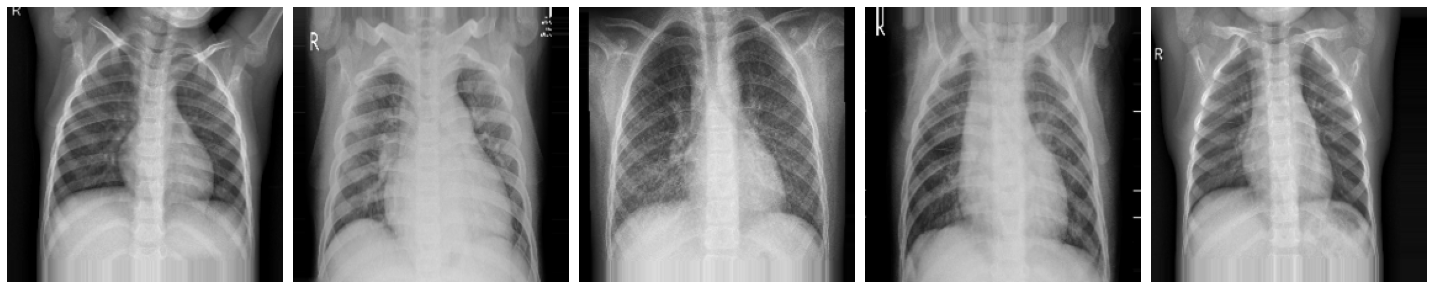

In [10]:
training_images, training_labels = next(train_data_gen) 

plotImages(training_images[:5])

In [11]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D())

    model.add(Conv2D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))

    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))

    model.add(Dropout(0.2))
    model.add(Dense(3))
    
    return model

In [12]:
model = create_model()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_data_gen, 
                    steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=test_data_gen,
                    validation_steps=int(np.ceil(test_data_gen.n / float(BATCH_SIZE)))
                    )

Epoch 1/25
20/20 [==============================] - ETA: 0s - loss: 1.7366 - accuracy: 0.3715
Epoch 00001: val_loss improved from inf to 0.94490, saving model to corona_model_callback10.h5
20/20 [==============================] - 21s 1s/step - loss: 1.7366 - accuracy: 0.3715 - val_loss: 0.9449 - val_accuracy: 0.6564 - lr: 0.0010
Epoch 2/25
20/20 [==============================] - ETA: 0s - loss: 0.7921 - accuracy: 0.6317
Epoch 00002: val_loss improved from 0.94490 to 0.47503, saving model to corona_model_callback10.h5
20/20 [==============================] - 22s 1s/step - loss: 0.7921 - accuracy: 0.6317 - val_loss: 0.4750 - val_accuracy: 0.8528 - lr: 0.0010
Epoch 3/25
20/20 [==============================] - ETA: 0s - loss: 0.5453 - accuracy: 0.7853
Epoch 00003: val_loss improved from 0.47503 to 0.30894, saving model to corona_model_callback10.h5
20/20 [==============================] - 22s 1s/step - loss: 0.5453 - accuracy: 0.7853 - val_loss: 0.3089 - val_accuracy: 0.9080 - lr: 0.0010

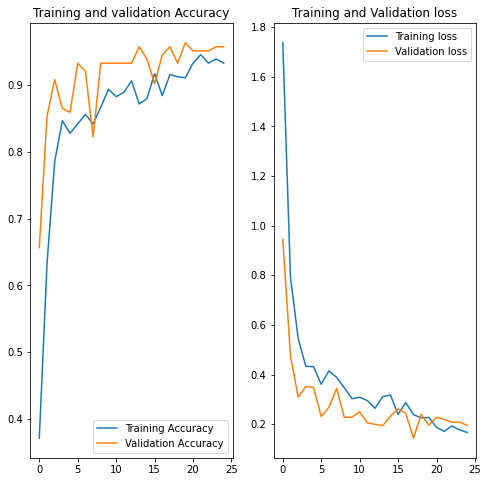

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

learningCurve(epochs_range=epochs_range, 
              acc=acc, 
              val_acc=val_acc, 
              loss=loss, 
              val_loss=val_loss)


In [14]:
test_loss, test_acc = model.evaluate(test_data_gen)

6/6 [==============================] - 1s 246ms/step - loss: 0.1953 - accuracy: 0.9571


In [15]:
model.save('dirty_covid_model.h5')

In [16]:
from tensorflow.keras.models import load_model

classifier = load_model('dirty_covid_model.h5')

In [17]:
classifier.evaluate(test_data_gen, verbose=1)

6/6 [==============================] - 1s 232ms/step - loss: 0.1953 - accuracy: 0.9571


[0.19534869492053986, 0.9570552110671997]